In [1]:
from oggm import utils
import geopandas as gpd
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL, global_task
import xarray as xr
import matplotlib.pyplot as plt
from oggm.global_tasks import compile_fixed_geometry_mass_balance
import pandas as pd
from oggm.shop import gcm_climate

In [2]:
glacier = 'RGI60-19.02266'

2024-05-04 10:38:21: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-04 10:38:21: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-04 10:38:21: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-04 10:38:21: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-05-04 10:38:21: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-05-04 10:38:43: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-04 10:38:45: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-04 10:38:47: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-04 10:38:48: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-04 10:38:49: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-04 10:38:49: oggm.workflow: Ex

<xarray.Dataset>
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 'RGI60-19.02266'
    hydro_year      (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    hydro_month     (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
    calendar_year   (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 1.465e+10 1.444e+10 ... 4.652e+09
    volume_bsl      (time, rgi_id) float64 2.936e+09 2.86e+09 ... 0.0 0.0
    volume_bwl      (time, rgi_id) float64 2.936e+09 2.86e+09 ... 0.0 0.0
    area            (time, rgi_id) float64 1.03e+08 1.029e+08 ... 5.516e+07
    length          (time, rgi_id) float64 1.085e+04 1.085e+04 ... 4.03e+03
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    calving_rat

2024-05-04 10:38:50: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-05-04 10:38:50: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-05-04 10:38:51: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-05-04 10:38:51: oggm.utils: Applying compile_run_output on 1 gdirs.


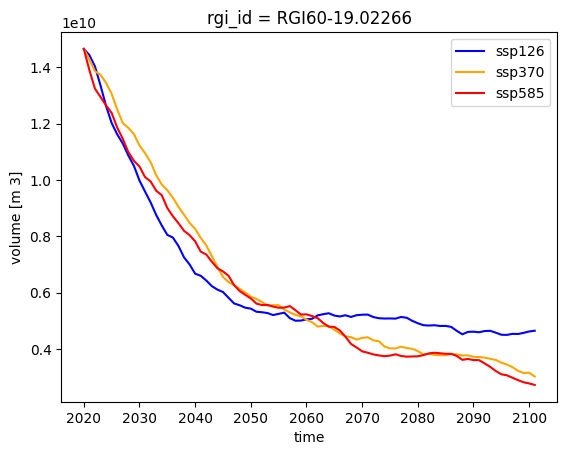

In [3]:
def initializa_gdir(glacier_name = 'RGI60-15.03473') :
    # Initialize OGGM and set up the default run parameters
    cfg.initialize(logging_level='WARNING')

    # Local working directory (where OGGM will write its output)
    # WORKING_DIR = utils.gettempdir('OGGM_distr4')
    cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

    rgi_ids = [glacier_name]  # This is Aletsch
    gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]
    return gdir

def get_volumes_by_scenario(glacier_name) : 
    # Initialisation du glacier_directory
    cfg.initialize(logging_level='WARNING')
    cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_gcm_run', reset=True)
    rgi_ids = [glacier_name]
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=DEFAULT_BASE_URL)

    # Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)
    # C'est déjà calculé sur leurs serveurs (ils ont 3 scénarios SSP de pêts) donc on les télécharge
    member = 'mri-esm2-0_r1i1p1f1' 

    for ssp in ['ssp126', 'ssp370','ssp585']:
        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                    ssp = ssp,
                                    # gcm member -> you can choose another one
                                    member=member,
                                    # recognize the climate file for later
                                    output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                    );

    # Si on veut des infos sur le climat: 
    #print(gdirs[0].get_climate_info())

    # On lance les calculs de projection dans le futur pour chacun des 3 scénarios SSP
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                    climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                    climate_input_filesuffix=rid,  # use the chosen scenario
                                    init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                    output_filesuffix=rid,  # recognize the run for later
                                    );
    
    # On récupère les données de volume pour chaque scénario
    # On plot les volumes pour chaque scénario
    color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}
    scenarios = []
    for ssp in ['ssp126','ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        # Compile the output into one file
        ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
        scenarios.append(ds)
        print(ds)
        # Plot it
        ds.isel(rgi_id=0).volume.plot(label=ssp, c=color_dict[ssp]);
    plt.legend();
    return scenarios


volumes_futurs = get_volumes_by_scenario(glacier)


gdir = initializa_gdir(glacier)
ds = utils.compile_run_output(gdir, input_filesuffix='_spinup_historical') # sert à récupérer les données de volume


volume_reel = ds.volume.values
years_reel = ds.time.values

years_proj = volumes_futurs[0].time.values


import numpy as np
scenario_1_ssp126 = np.concatenate((volume_reel[:-1], volumes_futurs[0].volume.values))
scenario_2_ssp370 = np.concatenate((volume_reel[:-1], volumes_futurs[1].volume.values))
scenario_3_ssp585 = np.concatenate((volume_reel[:-1], volumes_futurs[2].volume.values))
years_total = np.concatenate((years_reel[:-1], years_proj))

In [4]:
import csv

# field names 
fields = ['year', 'scenario_1_ssp126', 'scenario_2_ssp370', 'scenario_3_ssp585'] 

scenario_1_ssp126 = scenario_1_ssp126.flatten()
scenario_2_ssp370 = scenario_2_ssp370.flatten()
scenario_3_ssp585 = scenario_3_ssp585.flatten()

columns = [years_total, scenario_1_ssp126, scenario_2_ssp370, scenario_3_ssp585]

filename = "volume_scenarios_" + glacier + ".csv"
print(filename)
with open(filename, 'w') as f:
	write = csv.writer(f)
	write.writerow(fields)  # Write the field names
	write.writerows(zip(*columns))

volume_scenarios_RGI60-19.02266.csv
